In [1]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
# import packages
import pandas as pd
from political_ads.Preprocessor import *
from political_ads.helper import *
from political_ads.keyword_filter import *
import matplotlib.pyplot as plt

In [2]:
#Code to read from our full dataset:
preprocess = Preprocessor()
df = preprocess.file_to_df('/home/gustavgyrst/Desktop/research_project/political-ad-api/data/all_politicians_aggregated.txt')
df.head(3)


,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
0,2021-10-14,To show that you're part of our fight to prote...,1749.5,74999.5,"[{'percentage': '0.004793', 'region': 'Alabama...","[{'percentage': '0.010689', 'age': '18-24', 'g...",38471053686,Elizabeth Warren,"WARREN DEMOCRATS, INC.",195916456012328,1500,1999,70000,79999
1,2021-10-14,Nothing is spookier than the ongoing assault o...,149.5,27499.5,"[{'percentage': '0.005051', 'region': 'Alabama...","[{'percentage': '0.000629', 'age': '18-24', 'g...",38471053686,Elizabeth Warren,"WARREN DEMOCRATS, INC.",197833945796073,100,199,25000,29999
2,2021-10-14,To show that you're part of our fight to prote...,1749.5,162499.5,"[{'percentage': '0.004873', 'region': 'Alabama...","[{'percentage': '0.005081', 'age': '18-24', 'g...",38471053686,Elizabeth Warren,"WARREN DEMOCRATS, INC.",396978045241497,1500,1999,150000,174999


In [78]:
#If representation for climate ads is wanted:
c_filter = Filter()
df_climate = c_filter.get_climate_ads(df)


In [79]:
total_climate_ad_count = len(df_climate)

In [80]:
#General stats
print("There are", len(df[df.impressions_lo == 1000000]), "ads with spending of $1,000,000 or above in the data-set")
print(len(df), "ads in total")
print("There are", len(df.dropna(subset=['demographic_distribution'])), "ads after dropping the nan values in the demographic data")
print(total_climate_ad_count)

There are 600 ads with spending of $1,000,000 or above in the data-set
602546 ads in total
There are 463403 ads after dropping the nan values in the demographic data
19176


In [81]:
df['demographic_distribution'][0]

[{'percentage': '0.010689', 'age': '18-24', 'gender': 'female'},
 {'percentage': '0.175559', 'age': '35-44', 'gender': 'female'},
 {'percentage': '0.003656', 'age': '55-64', 'gender': 'unknown'},
 {'percentage': '0.009856', 'age': '18-24', 'gender': 'male'},
 {'percentage': '0.004535', 'age': '45-54', 'gender': 'unknown'},
 {'percentage': '0.006802', 'age': '35-44', 'gender': 'unknown'},
 {'percentage': '0.0478', 'age': '25-34', 'gender': 'male'},
 {'percentage': '0.035584', 'age': '45-54', 'gender': 'male'},
 {'percentage': '0.175327', 'age': '45-54', 'gender': 'female'},
 {'percentage': '0.004072', 'age': '25-34', 'gender': 'unknown'},
 {'percentage': '0.03216', 'age': '55-64', 'gender': 'male'},
 {'percentage': '0.162325', 'age': '55-64', 'gender': 'female'},
 {'percentage': '0.003933', 'age': '65+', 'gender': 'unknown'},
 {'percentage': '0.042062', 'age': '35-44', 'gender': 'male'},
 {'percentage': '0.037481', 'age': '65+', 'gender': 'male'},
 {'percentage': '0.161075', 'age': '65+

# 1. Demographic Distribution


In [82]:
#lst of failed attempts
lst_of_failed = []
#The list that will be returned
lst  = []

#Get age distribution
def get_age_distribution(row, gender):
    #The list that will be returned
    lst  = []

    #The map of age_dist
    age_dist = {'13-17': 0.0, '18-24': 0.0, '25-34':0.0, '35-44':0.0, '45-54':0.0, '55-64':0.0, '65+':0.0, 'Unknown': 0.0} #important that Unknown is with capital U
    
    for item in row.demographic_distribution:
        
            try:
                if item['gender'] == gender:
                    age = item['age']
                    percentage = float(item['percentage'])
                    age_dist[age] = age_dist.get(age) + percentage
                else: 
                    pass
            except:
                lst_of_failed.append(row[['page_name', 'demographic_distribution']])
                pass  
    
    for key, value in age_dist.items():
        lst.append(value*(row['impressions_hi']/2)) # CHANGED SOMETHING HERE NOT TESTED

    return pd.Series(lst)

In [83]:
NaNs = df[df['demographic_distribution'].isna() == True]
print("Amount of NaNs values in the demographic_distribution field:", len(NaNs))
NaNs.head(1)

NaNs_climate = df_climate[df_climate['demographic_distribution'].isna() == True]
print(len(NaNs_climate), " climate ads NaNs") 
print(len(df_climate),"climate ads in total")
print("after nan removal", len(df_climate) - len(NaNs_climate))
print(len(NaNs) / len(df))

Amount of NaNs values in the demographic_distribution field: 139143
5710  climate ads NaNs
19176 climate ads in total
after nan removal 13466
0.23092510779260006


In [84]:
#For filtering for NaN values and preparing the dataframe to have the different values i.e., age-groupings 
def create_demographic_df(df:DataFrame):
     demographics = df[['page_id', 'page_name', 'demographic_distribution', 'impressions_hi']].reset_index().drop(columns='index')
     print(len(demographics))
     demographics = demographics.dropna()
     print("Are there nans?:", demographics.isna().any())
     
     #Creating the Columns
     age_dist_lst = ['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']
     for i in age_dist_lst:
          demographics[i] = 0.0

     return demographics




In [85]:
#INSERT the set of ads that you want to run the complete process on e.g., df_climate or df (all ads)
#Change this True/False depending on what is wanted to be displayed in the data
climate_ads_only = True
#Party = 'Democrat'

In [86]:

if climate_ads_only == False:
    demographics = create_demographic_df(df)
else:
    demographics = create_demographic_df(df_climate)

demographics.head(1)


19176
Are there nans?: page_id                     False
page_name                   False
demographic_distribution    False
impressions_hi              False
dtype: bool


,page_id,page_name,demographic_distribution,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,38471053686,Elizabeth Warren,"[{'percentage': '0.003529', 'age': '25-34', 'g...",999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
demographics_male = demographics.copy()
demographics_female = demographics.copy()
demographics_unknown = demographics.copy()

In [88]:
#Running for male
demographics_male[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row=x, gender='male'), axis=1)

In [89]:
#Running for male
demographics_female[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='female'), axis=1)

In [90]:
demographics_unknown[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='unknown'), axis=1)

In [91]:
demographics_male['gender'] = 'male'
demographics_female['gender'] = 'female'
demographics_unknown['gender'] = 'unknown'


In [92]:
demographics_male_g = demographics_male.groupby('page_name').sum()
demographics_female_g = demographics_female.groupby('page_name').sum()
demographics_unknown_g = demographics_unknown.groupby('page_name').sum()



demographics_male_g['gender'] = 'male'
demographics_female_g['gender'] = 'female'
demographics_unknown_g['gender'] = 'unknown'


In [93]:
frames = [demographics_female_g,demographics_male_g,demographics_unknown_g]
total = pd.concat(frames)


In [94]:
test = total.groupby('gender').sum()

In [95]:
test.reset_index(inplace=True)
test

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,124043542,12056.197839,4.984708e+06,7.382695e+06,6.023516e+06,5.085830e+06,6.067646e+06,7.624619e+06,0.000000
1,male,124043542,8021.966312,2.937631e+06,5.843017e+06,4.181057e+06,3.381905e+06,3.532225e+06,4.115252e+06,0.000000
2,unknown,124043542,450.136727,1.190935e+05,1.964581e+05,1.524291e+05,1.050508e+05,1.118950e+05,1.556795e+05,530.895853


In [96]:
test.set_index('gender', inplace=True)


In [97]:
#dropping some columns
test.drop(columns='impressions_hi', inplace=True)
test.drop(columns='13-17', inplace=True)
test.drop(columns='unknown', inplace=True)

<AxesSubplot:>

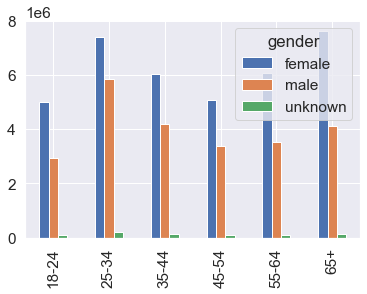

In [98]:
#Overall distribution for all politicians
test.T.plot(kind='bar', style='Spring')


In [99]:
test_2 = test.T.drop(columns='unknown')
test_2 = test_2.reset_index()


In [100]:
test_2['male'] = test_2['male'].apply(lambda x: x*(-1))


In [101]:
test_2

gender,index,female,male
0,18-24,4.984708e+06,-2.937631e+06
1,25-34,7.382695e+06,-5.843017e+06
2,35-44,6.023516e+06,-4.181057e+06
3,45-54,5.085830e+06,-3.381905e+06
4,55-64,6.067646e+06,-3.532225e+06
5,65+,7.624619e+06,-4.115252e+06


[Text(0.5, 0, 'Population (hundreds of millions)'),
 Text(0, 0.5, 'Age-Group'),
 Text(0.5, 1.0, 'Total population distribution')]

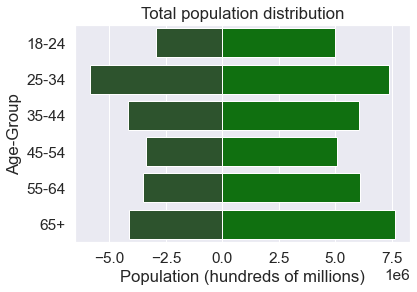

In [102]:
import seaborn as sns

sns.color_palette("Blues", as_cmap=True)


age_class = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

pyramid = sns.barplot(x='male', y='index', data=test_2, order=age_class, color="green", saturation=0.3)
pyramid = sns.barplot(x='female', y='index', data=test_2, order=age_class, color="green", saturation=0.75)

pyramid.set(xlabel="Population (hundreds of millions)", ylabel="Age-Group", title = "Total population distribution")


In [103]:
test

,18-24,25-34,35-44,45-54,55-64,65+
gender,,,,,,
female,4.984708e+06,7.382695e+06,6.023516e+06,5.085830e+06,6.067646e+06,7.624619e+06
male,2.937631e+06,5.843017e+06,4.181057e+06,3.381905e+06,3.532225e+06,4.115252e+06
unknown,1.190935e+05,1.964581e+05,1.524291e+05,1.050508e+05,1.118950e+05,1.556795e+05


# Democrats vs. Republicans

In [104]:
congress = pd.read_csv('/home/gustavgyrst/Desktop/research_project/political-ad-api/src/data_sets/legislators_fb_info_final.csv')


In [105]:
congress


,Unnamed: 0,Unnamed: 0.1,first_name,last_name,full_name,type,state,district,party,facebook,page_name,identifier,page_id
0,0,0,Sherrod,Brown,Sherrod Brown,sen,OH,NaN,Democrat,SenatorSherrodBrown,NaN,0,6266829799
1,1,1,Maria,Cantwell,Maria Cantwell,sen,WA,NaN,Democrat,senatorcantwell,Senator Maria Cantwell,100044609161538,9351652533
2,2,2,Benjamin,Cardin,Benjamin L. Cardin,sen,MD,NaN,Democrat,senatorbencardin,Senator Ben Cardin,100044326544838,no match
3,3,3,Thomas,Carper,Thomas R. Carper,sen,DE,NaN,Democrat,tomcarper,Senator Tom Carper,100044593172202,165571920202215
4,4,4,Robert,Casey,"Robert P. Casey, Jr.",sen,PA,NaN,Democrat,SenatorBobCasey,U.S. Senator Bob Casey,100044143479624,6781166087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,533,533,Claudia,Tenney,Claudia Tenney,rep,NY,22.0,Republican,NaN,NaN,0,183020072173458
534,534,534,Julia,Letlow,Julia Letlow,rep,LA,5.0,Republican,NaN,NaN,0,101501768597429
535,535,535,Troy,Carter,Troy A. Carter,rep,LA,2.0,Democrat,NaN,NaN,0,876319055750124
536,536,536,Melanie,Stansbury,Melanie A. Stansbury,rep,NM,1.0,Democrat,NaN,NaN,0,128551641258085


In [106]:
congress.at[8, 'party'] = 'Democrat'

congress[congress.last_name == 'Sanders']

,Unnamed: 0,Unnamed: 0.1,first_name,last_name,full_name,type,state,district,party,facebook,page_name,identifier,page_id
8,8,8,Bernard,Sanders,Bernard Sanders,sen,VT,NaN,Democrat,senatorsanders,U.S. Senator Bernie Sanders,100044564583792,124955570892789


# CHOOSE PARTY

In [130]:

#Here one can decide which party one wants to have represented in the data
party = 'Democrat'

party_members = congress[congress["party"] == party]  # get all page id's that match the given party

#Male
demographics_democrats_male = demographics_male[demographics_male.page_id.isin(party_members.page_id)] # get all the ads where page id matches with the party page id's

#Female
demographics_democrats_female = demographics_female[demographics_female.page_id.isin(party_members.page_id)] # get all the ads where page id matches with the party page id's

#Unknown
demographics_democrats_unknown = demographics_unknown[demographics_unknown.page_id.isin(party_members.page_id)]


In [131]:
demographics_democrats_male_g = demographics_democrats_male.groupby('page_id').sum()
demographics_democrats_female_g = demographics_democrats_female.groupby('page_id').sum()
demographics_democrats_unknown_g = demographics_democrats_unknown.groupby('page_id').sum()

demographics_democrats_male_g['gender'] = 'male'
demographics_democrats_female_g['gender'] = 'female'
demographics_democrats_unknown_g['gender'] = 'unknown'


In [132]:
#concatenating the frames
frames_democrats = [demographics_democrats_female_g,demographics_democrats_male_g,demographics_democrats_unknown_g]
total_democrats = pd.concat(frames_democrats)


In [133]:
democrats = total_democrats.groupby('gender').sum()


In [134]:
democrats

,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
gender,,,,,,,,,
female,122743611,12056.197839,4.974480e+06,7.328034e+06,5.949510e+06,5.026583e+06,5.997036e+06,7.515251e+06,0.000000
male,122743611,8021.966312,2.922182e+06,5.814363e+06,4.155307e+06,3.342718e+06,3.462137e+06,4.024962e+06,0.000000
unknown,122743611,450.136727,1.190093e+05,1.962436e+05,1.521158e+05,1.046754e+05,1.113334e+05,1.548029e+05,530.895853


In [135]:
democrats.reset_index(inplace=True)



In [136]:
democrats

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,122743611,12056.197839,4.974480e+06,7.328034e+06,5.949510e+06,5.026583e+06,5.997036e+06,7.515251e+06,0.000000
1,male,122743611,8021.966312,2.922182e+06,5.814363e+06,4.155307e+06,3.342718e+06,3.462137e+06,4.024962e+06,0.000000
2,unknown,122743611,450.136727,1.190093e+05,1.962436e+05,1.521158e+05,1.046754e+05,1.113334e+05,1.548029e+05,530.895853


In [137]:
democrats2 = democrats.drop(democrats.index[2])

In [138]:
democrats2

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,122743611,12056.197839,4.974480e+06,7.328034e+06,5.949510e+06,5.026583e+06,5.997036e+06,7.515251e+06,0.0
1,male,122743611,8021.966312,2.922182e+06,5.814363e+06,4.155307e+06,3.342718e+06,3.462137e+06,4.024962e+06,0.0


In [139]:
democrats.set_index('gender', inplace=True)


In [140]:
democrats.drop(columns=['impressions_hi', '13-17', 'unknown'], inplace=True)
democrats2.drop(columns=['impressions_hi', '13-17', 'unknown'], inplace=True)

In [141]:
democrats2 = democrats2.set_index('gender')


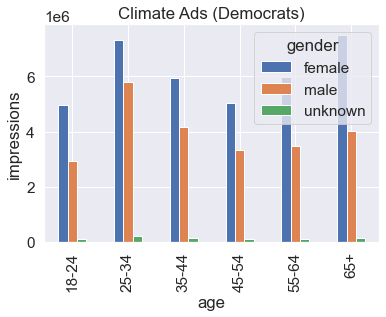

In [142]:
title = "Climate Ads" + " (" + party + "s)"
plot = democrats.T.plot(kind='bar', style='blues' , title=title, ylabel='impressions', xlabel='age')

fig = plot.get_figure()
#fig.savefig("Republicans_with_unknown_demographic_dist_climate_ads.pdf")


In [143]:
democrats2.T

gender,female,male
18-24,4.974480e+06,2.922182e+06
25-34,7.328034e+06,5.814363e+06
35-44,5.949510e+06,4.155307e+06
45-54,5.026583e+06,3.342718e+06
55-64,5.997036e+06,3.462137e+06
65+,7.515251e+06,4.024962e+06


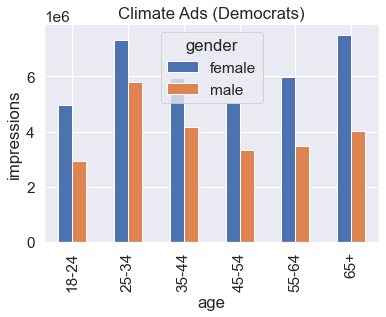

In [144]:

plot_without_unknowns = democrats2.T.plot(kind='bar', style='spring', title=title, ylabel='impressions', xlabel='age')
fig = plot.get_figure()
#fig.savefig("Republicans_demographic_dist_climate_ads.pdf")


In [145]:
democrats2_modified = democrats2.T.reset_index()


In [146]:
democrats2_modified


gender,index,female,male
0,18-24,4.974480e+06,2.922182e+06
1,25-34,7.328034e+06,5.814363e+06
2,35-44,5.949510e+06,4.155307e+06
3,45-54,5.026583e+06,3.342718e+06
4,55-64,5.997036e+06,3.462137e+06
5,65+,7.515251e+06,4.024962e+06


In [147]:

democrats2_modified['male'] = democrats2_modified['male'].apply(lambda x: x*(-1))

In [148]:
'''
Function for nice axis dollar formatting
'''
sns.set(font_scale=1.4)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if (tick_val >= 1000000000) | (tick_val<= -1000000000):
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(abs(val))
    elif (tick_val >= 1000000) | (tick_val<= -1000000):
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(abs(val))
    elif (tick_val >= 1000) | (tick_val<= -1000):
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(abs(val))
    elif (tick_val < 1000)| (tick_val<= 0):
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

['65+', '55-64', '45-54', '35-44', '25-34', '18-24']


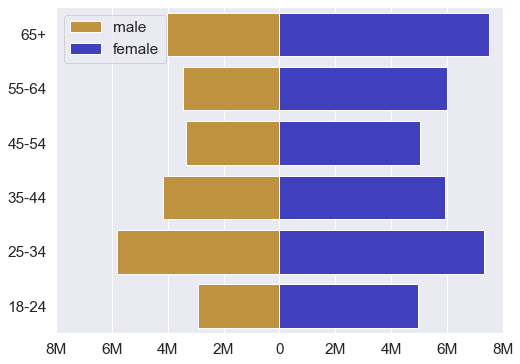

In [153]:
age_class = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

age_class.sort(reverse=True)
print(age_class)
import matplotlib.ticker as tick
import matplotlib.pyplot as plt

figure, ax = plt.subplots(figsize=(8,6))

pyramid_byparty = sns.barplot(x='male', y='index', data=democrats2_modified, order=age_class, color="orange", saturation=0.50, label='male')
pyramid_byparty = sns.barplot(x='female', y='index', data=democrats2_modified, order=age_class, color="blue", saturation=0.50, label='female')

pyramid_byparty.set(title = "")

ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

ax.legend(ncol=1, loc="lower right", frameon=True)

if climate_ads_only == True:
    if party == "Republican":
        plt.xlim([-100000, 100000])
    else:
        plt.xlim([-8000000,8000000])
else:
    if party == "Republican":
        plt.xlim([-300000000, 300000000])
    else:
        plt.xlim([-370000000, 370000000])
    

plt.ylabel("")
plt.xlabel("")
ax.legend()


In [154]:
fig_pop = pyramid_byparty.get_figure()
if climate_ads_only == True:
    fig_name = party + "_climate_ads_demographic_pyramid.pdf"
else:
    fig_name = party + "_all_ads_demographic_pyramid.pdf"

#Saving it to the subfolder:
fig_pop.savefig("/home/gustavgyrst/Desktop/research_project/political-ad-api/plots/demographics/" +fig_name)

# Older Code:

# Gender Distribution (Alone)

In [155]:
#Random sum check
sum = 0
for i in df.demographic_distribution[0]:
    sum += float(i.get('percentage'))
print("The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100", sum)
#So... they don't even sum up to a hundred



The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100 1.0000010000000001


In [156]:
list_of_failed_g = []
count_unknown =0
def get_gender_distribution(row):
    
    #initializing percentages
    percentage_male = 0.0
    percentage_female = 0.0
    percentage_unknown = 0.0

    try:
        for item in row.demographic_distribution:
            if item['gender'] == 'male':
                percentage_male += float(item['percentage'])
            elif item['gender'] == 'female':
                percentage_female += float(item['percentage'])
            elif item['gender'] == 'unknown':
                percentage_unknown += float(item['percentage'])
                count_unknown+=1
    except:
        list_of_failed_g.append(lst)
    
    avg_imp = float(row['avg_impressions'])
    lst_all_genders = [percentage_male, percentage_female, percentage_unknown]
    for i in range(3):
        lst_all_genders[i] = lst_all_genders[i]*avg_imp
    
    #Getting the avg impression to get the weight of the gender distribution
    return pd.Series(lst_all_genders)